# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [83]:
#Dependencies
import requests
import json
from api_keys import weather_api_key
import numpy as np
import pandas as pd
from citipy import citipy
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

url = "http://api.openweathermap.org/data/2.5/weather?"


## Generate Cities List

In [84]:
#Create variables for the random selcetion of latitudes and longitudes with limits
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create lists for holding coordinates and city names
lat_lngs = []
cities = []

# Create a set of 1200 random latitude and longitude combinations
##NB: Many of these combinations will return the same city, so more are generated to end with 
## the minimum required 500 cities

lats = np.random.uniform(low=-90.000, high=90.000, size=1400)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1400)

#Zip the lats and longs together to form coordinate pairs
lats_lngs = zip(lats, lngs)

#Loop through the list, using citipy to locate the closest city to each coordinate set
for lat_lng in lats_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    cities.append(city)



In [59]:
#create a dataframe to hold city information
df = pd.DataFrame({"City Name": cities,
                   "Latitude": "",
                   "Longitude": "",
                   "Max Temp": "",
                   "Humidity": "",
                   "Cloudiness": "",
                   "Wind Speed": "",
                   "Country": "",
                   "City Date/Time": ""})

#Remove any duplicate rows based on city name
df = df.drop_duplicates(subset=["City Name"], ignore_index=True)
df

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,City Date/Time
0,komsomolskiy,,,,,,,,
1,lebu,,,,,,,,
2,eyl,,,,,,,,
3,oga,,,,,,,,
4,ushuaia,,,,,,,,
...,...,...,...,...,...,...,...,...,...
560,robertsport,,,,,,,,
561,novoagansk,,,,,,,,
562,mareeba,,,,,,,,
563,itarema,,,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [85]:
# Use a for loop to build the query url from DataFrame of city names
## Use try and except functions to skip over rows with no weather information available
for index, row in df.iterrows():
    
    try:
        city = row["City Name"]
    
        query_url = f"{url}appid={weather_api_key}&q={city}&units=metric"
    
        response = requests.get(query_url)
        cities_info = response.json()

        #Store the exact latitude and longitude values for each city
        df.loc[index, "Latitude"] = cities_info['coord']['lat']
        df.loc[index, "Longitude"] = cities_info['coord']['lon']
        df.loc[index, "Max Temp"] = cities_info["main"]["temp_max"]
        df.loc[index, "Humidity"] = cities_info["main"]["humidity"]
        df.loc[index, "Cloudiness"] = cities_info["clouds"]["all"]
        df.loc[index, "Wind Speed"] = cities_info["wind"]["speed"]
        df.loc[index, "Country"] = cities_info["sys"]["country"]
        df.loc[index, "City Date/Time"] = cities_info["dt"]
    
    except KeyError:
        print(f"No data available for {city}")
    
    #Print log of city as it is checked
    print(f"Checking weather at {city}, city number {index + 1}")


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Checking weather at komsomolskiy, city number 1
Checking weather at lebu, city number 2
Checking weather at eyl, city number 3
Checking weather at oga, city number 4
Checking weather at ushuaia, city number 5
Checking weather at oranjemund, city number 6
Checking weather at tasiilaq, city number 7
Checking weather at upernavik, city number 9
Checking weather at tiksi, city number 10
Checking weather at hermanus, city number 12
Checking weather at kosh-agach, city number 13
Checking weather at cape town, city number 14
Checking weather at clyde river, city number 15
Checking weather at airai, city number 16
Checking weather at new norfolk, city number 18
Checking weather at presidencia roque saenz pena, city number 19
Checking weather at healdsburg, city number 20
Checking weather at sur, city number 21
Checking weather at impfondo, city number 22
Checking weather at hambantota, city number 23
Checking weather at san patricio, city number 24
Checking weather at albany, city number 25
Ch

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [61]:
#Convert values from API to numerical values, in order to plot later
df["Latitude"] = pd.to_numeric(df["Latitude"], errors='coerce')
df["Longitude"] = pd.to_numeric(df["Longitude"], errors='coerce')
df["Max Temp"] = pd.to_numeric(df["Max Temp"], errors='coerce')
df["Humidity"] = pd.to_numeric(df["Humidity"], errors='coerce')
df["Cloudiness"] = pd.to_numeric(df["Cloudiness"], errors='coerce')
df["Wind Speed"] = pd.to_numeric(df["Wind Speed"], errors='coerce')

#Save dataframe as a csv
df.to_csv('../Cities_Weather_Info.csv')

#Remove rows with no weather information available
df = df.dropna()
df


,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,City Date/Time
0,komsomolskiy,40.4272,71.7189,23.40,40.0,100.0,1.03,UZ,1651053980
1,lebu,-37.6167,-73.6500,11.07,84.0,85.0,9.86,CL,1651053925
2,eyl,7.9803,49.8164,31.06,57.0,83.0,5.40,SO,1651054231
3,oga,46.4631,10.3470,11.56,64.0,6.0,1.97,IT,1651054232
4,ushuaia,-54.8000,-68.3000,1.58,97.0,98.0,3.77,AR,1651054232
...,...,...,...,...,...,...,...,...,...
559,coihaique,-45.5752,-72.0662,-1.03,93.0,0.0,1.54,CL,1651053947
560,robertsport,6.7533,-11.3686,28.26,75.0,97.0,1.89,LR,1651054340
561,novoagansk,61.9449,76.6625,5.07,100.0,100.0,5.92,RU,1651054340
562,mareeba,-17.0000,145.4333,23.40,88.0,60.0,1.42,AU,1651054340


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [62]:
#Check to see if there are any values of humidity over 100%
humid = df.loc[df['Humidity'] > 100]
humid

#Repeated trials did not pull any data for this step

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,City Date/Time


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

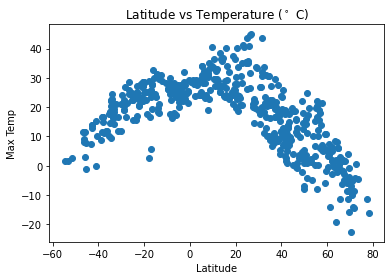

In [63]:
plt.scatter(df['Latitude'], df['Max Temp'])
plt.title("Latitude vs Temperature ($^\circ$ C)")
plt.ylabel("Max Temp")
plt.xlabel("Latitude")

plt.savefig("Images/Latitude_vs_Temperature.png")

While there are some outliers, this graph shows that as latitudes approach the equator (that is, 0 degrees latitude) temperature increases. 

## Latitude vs. Humidity Plot

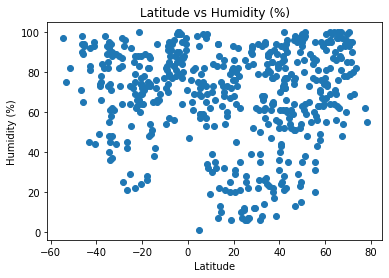

In [64]:
plt.scatter(df['Latitude'], df['Humidity'])
plt.title("Latitude vs Humidity (%)")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")

plt.savefig("Images/Latitude_vs_Humidity.png")

In [65]:
#Correlation coefficient calculation
correlation = st.pearsonr(df['Latitude'], df['Humidity'])
print(f"The correlation between latitude and humidity is {round(correlation[0],2)}")

The correlation between latitude and humidity is -0.02


The above graph of latitude vs humidity appears to show that there is no, or very little correlation between humidity and latitude. This can be further proven with the correlation coefficient calculated above.

## Latitude vs. Cloudiness Plot

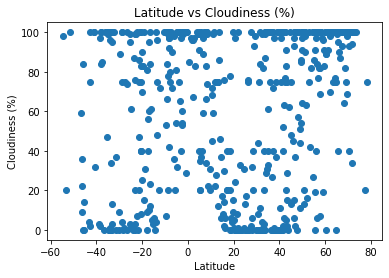

In [66]:
plt.scatter(df['Latitude'], df['Cloudiness'])
plt.title("Latitude vs Cloudiness (%)")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")

plt.savefig("Images/Latitude_vs_Cloudiness.png")

The graph above shows the relationship between latitudes and cloud cover - of which there appears to be no correlation with cloud cover varying greatly across similar latitudes.

## Latitude vs. Wind Speed Plot

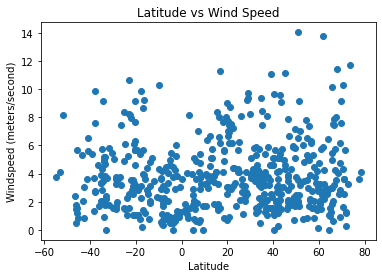

In [67]:
plt.scatter(df['Latitude'], df['Wind Speed'])
plt.title("Latitude vs Wind Speed")
plt.ylabel("Windspeed (meters/second)")
plt.xlabel("Latitude")

plt.savefig("Images/Latitude_vs_WindSpeed.png")

The graph of latitude vs windspeed shows several outliers, however again very limited correaltion between latitude and wind speed. 

## Linear Regression

In [68]:
#Create separate dataframes for northern and southern hemispheres
northern_hemisphere = df.loc[df['Latitude'] >= 0]
southern_hemisphere = df.loc[df['Latitude'] < 0]



####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

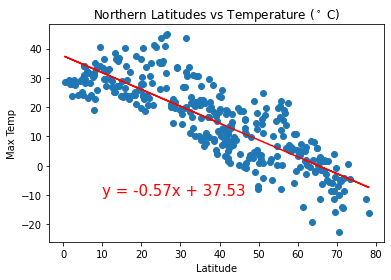

In [82]:
#Calculate the linear regression model
x_values = northern_hemisphere['Latitude']
y_values = northern_hemisphere['Max Temp']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#Plot the chart
plt.scatter(northern_hemisphere['Latitude'], northern_hemisphere['Max Temp'])
plt.title("Northern Latitudes vs Temperature ($^\circ$ C)")
plt.ylabel("Max Temp")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,-10),fontsize=15,color="red")

#Save the graph to 'Images' folder
plt.savefig("Images/NorthernLatitudes_vs_Temperature.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

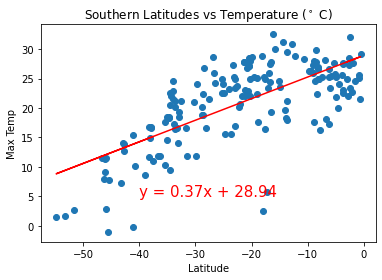

In [77]:
x_values = southern_hemisphere['Latitude']
y_values = southern_hemisphere['Max Temp']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(southern_hemisphere['Latitude'], southern_hemisphere['Max Temp'])
plt.title("Southern Latitudes vs Temperature ($^\circ$ C)")
plt.ylabel("Max Temp")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-40,5),fontsize=15,color="red")

plt.savefig("Images/SouthernLatitudes_vs_Temperature.png")

The above graphs show that for this set of 518 random cities, there is a stronger relationship between latitude and temperature above the equator than below. 

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

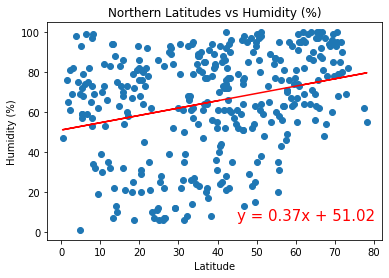

In [81]:
x_values = northern_hemisphere['Latitude']
y_values = northern_hemisphere['Humidity']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(northern_hemisphere['Latitude'], northern_hemisphere['Humidity'])
plt.title("Northern Latitudes vs Humidity (%)")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,6),fontsize=15,color="red")

plt.savefig("Images/NorthernLatitudes_vs_Humidity.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

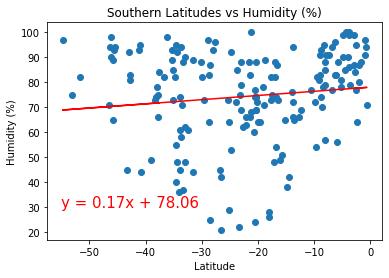

In [78]:
x_values = southern_hemisphere['Latitude']
y_values = southern_hemisphere['Humidity']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(southern_hemisphere['Latitude'], southern_hemisphere['Humidity'])
plt.title("Southern Latitudes vs Humidity (%)")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,30),fontsize=15,color="red")

plt.savefig("Images/SouthernLatitudes_vs_Humidity.png")

The above plots showing latitude vs humidity in the Northern and Southern Hemispheres show that humidity is generally increases with latitude. 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

y = 0.64x + 34.14


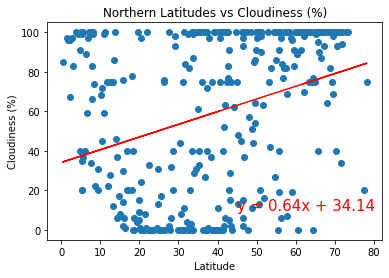

In [73]:
x_values = northern_hemisphere['Latitude']
y_values = northern_hemisphere['Cloudiness']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

plt.scatter(northern_hemisphere['Latitude'], northern_hemisphere['Cloudiness'])
plt.title("Northern Latitudes vs Cloudiness (%)")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,10),fontsize=15,color="red")

plt.savefig("Images/NorthernLatitudes_vs_Cloudiness.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

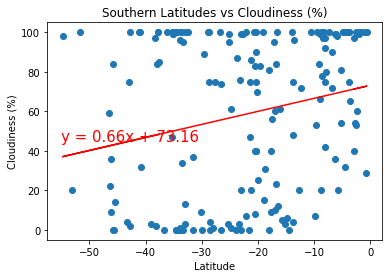

In [79]:
x_values = southern_hemisphere['Latitude']
y_values = southern_hemisphere['Cloudiness']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(southern_hemisphere['Latitude'], southern_hemisphere['Cloudiness'])
plt.title("Southern Latitudes vs Cloudiness (%)")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,45),fontsize=15,color="red")

plt.savefig("Images/SouthernLatitudes_vs_Cloudiness.png")

The above plots showing latitude vs cloudiness in the Northern and Southern Hemispheres show that cloudiness is not related proximity to the equator. 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

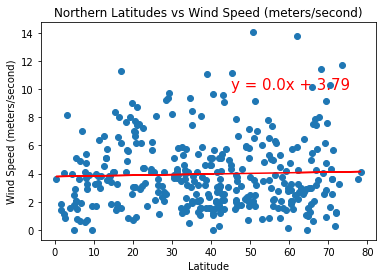

In [75]:
x_values = northern_hemisphere['Latitude']
y_values = northern_hemisphere['Wind Speed']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(northern_hemisphere['Latitude'], northern_hemisphere['Wind Speed'])
plt.title("Northern Latitudes vs Wind Speed (meters/second)")
plt.ylabel("Wind Speed (meters/second)")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,10),fontsize=15,color="red")

plt.savefig("Images/NorthernLatitudes_vs_WindSpeed.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

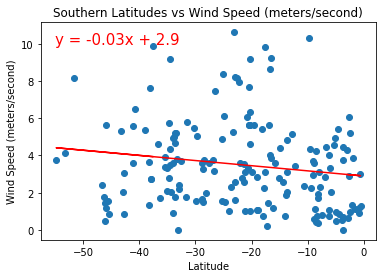

In [80]:
x_values = southern_hemisphere['Latitude']
y_values = southern_hemisphere['Wind Speed']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(southern_hemisphere['Latitude'], southern_hemisphere['Wind Speed'])
plt.title("Southern Latitudes vs Wind Speed (meters/second)")
plt.ylabel("Wind Speed (meters/second)")
plt.xlabel("Latitude")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,10),fontsize=15,color="red")

plt.savefig("Images/SouthernLatitudes_vs_WindSpeed.png")